In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# check GPU connection
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 16 02:17:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# required packages
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt


fGRU

In [ ]:
class fGRU(tf.keras.layers.Layer):
    '''
    Generates an fGRUCell
    params:
    hidden_channels: the number of channels which is constant throughout the
                     processing of each unit
    '''
    def __init__(
        self, 
        input_shape, 
        kernel_size=3, 
        padding='same', 
        use_attention=0, 
        channel_sym = True, 
        name = 'fGRU', 
        input_type = 'horizontal'):
        # channel_sym assigned False for speed. Saves 30 seconds.

        super().__init__(name = name)
        self.hidden_channels = input_shape[-1]
        self.kernel_size = kernel_size
        self.padding = padding
        self.channel_sym = channel_sym
        self.use_attention = use_attention
        self.input_shape_ = input_shape
        self.input_type = input_type # dealing with horizontal or vertical inputs

        if self.use_attention:
            # TODO: implement attention
            pass
        else:
            # Initialize convolutional kernels
            self.U_a = layers.Conv2D(
                filters=self.hidden_channels,
                kernel_size=1, 
                strides=1, 
                padding=self.padding,
                kernel_initializer=initializers.Orthogonal(),
                )
            
            self.U_m = layers.Conv2D(
                filters=1,
                kernel_size=self.kernel_size, 
                strides=1, 
                padding=self.padding,
                kernel_initializer=initializers.Orthogonal(),
                )
            
            self.W_s = layers.Conv2D(
                filters=self.hidden_channels,
                kernel_size=self.kernel_size, 
                strides=1, 
                padding=self.padding,
                kernel_initializer=initializers.Orthogonal(),
                )
            
            self.U_f = layers.Conv2D(
                filters=self.hidden_channels,
                kernel_size=self.kernel_size, 
                strides=1, 
                padding=self.padding,
                kernel_initializer=initializers.Orthogonal(),
                )
            
            self.W_f = layers.Conv2D(
                filters=self.hidden_channels,
                kernel_size=self.kernel_size, 
                strides=1, 
                padding=self.padding,
                kernel_initializer=initializers.Orthogonal(),
                )
        self.build(self.input_shape_)

        # initiate other weights
        self.alpha = tf.Variable(0.1, dtype='float32')
        self.mu = tf.Variable(0, dtype='float32')
        self.nu = tf.Variable(0, dtype='float32')
        self.omega = tf.Variable(0.1, dtype='float32')

    def channel_symmetrize(self):
        '''
        symmetrize the kernels channel-wise
        Somehow, if I write it in init, there will be the following error:
        'Conv2D' does not have attribute 'kernel'.
        '''
        if self.channel_sym: 
            for i in range(self.hidden_channels):
                for j in range(i, self.hidden_channels):
                    self.U_a.kernel[:,:,i,j].assign(self.U_a.kernel[:,:,j,i])
                    self.U_f.kernel[:,:,i,j].assign(self.U_f.kernel[:,:,j,i])
                    self.W_s.kernel[:,:,i,j].assign(self.W_s.kernel[:,:,j,i])
                    self.W_f.kernel[:,:,i,j].assign(self.W_f.kernel[:,:,j,i])

    def build(self, input_shape):
        self.U_a.build(input_shape)
        self.U_m.build(input_shape)
        self.U_f.build(input_shape)
        self.W_s.build(input_shape)
        self.W_f.build(input_shape)
        if self.channel_sym:
            self.channel_symmetrize()
        
        # initialize instance norm layers
        self.iN1 = InstanceNorm(self.hidden_channels)
        self.iN2 = InstanceNorm(self.hidden_channels)
        self.iN3 = InstanceNorm(self.hidden_channels)
        self.iN4 = InstanceNorm(self.hidden_channels)


    def call(self, z, h):
        '''
        Params: 
        Z: output from the last layer if fGRU-horizontal, hidden state of the
        current layer at t if fGRU-feedback.
        H: hidden state of the current layer at t-1 if fGRU-horizontal, output
        from the next layer if fGRU-feedback.
        '''

        # Stage 1: suppression
        a_s = self.U_a(h) # Compute channel-wise selection
        m_s = self.U_m(h) # Compute spatial selection
        # (note that U_a and U_m are kernels of different sizes and therefore
        # have different functions)

        m_s_expanded = tf.transpose(tf.convert_to_tensor([tf.transpose(m_s)[0]]*self.hidden_channels))
        g_s = tf.sigmoid(self.iN1(a_s * m_s_expanded))
        # Compute suppression gate
        c_s = self.iN2(self.W_s(h * g_s))
        # compute suppression interactions
        S = tf.keras.activations.relu(z - tf.keras.activations.relu((self.alpha * h + self.mu)*c_s))
        # Additive and multiplicative suppression of Z

        # Stage 2: facilitation
        g_f = tf.sigmoid(self.iN3(self.U_f(S)))
        # Compute channel-wise recurrent updates
        c_f = self.iN4(self.W_f(S))
        # Compute facilitation interactions
        h_tilda = tf.keras.activations.relu(self.nu*(c_f + S) + self.omega*(c_f * S))
        # Additive and multiplicative facilitation of S
        ht = (1 - g_f) * h + g_f * h_tilda
        # Update recurrent state
        return ht

class InstanceNorm(tf.keras.layers.Layer):
    def __init__(self, hidden_channels, name = 'instance_norm'):
        super().__init__(name = name)
        self.hidden_channels = hidden_channels
        self.omicron = tf.Variable(np.zeros(self.hidden_channels), dtype='float32')
        self.eta = tf.Variable(np.random.rand(self.hidden_channels), dtype='float32')
        self.delta = tf.Variable(np.zeros(self.hidden_channels)+0.1, dtype='float32')

    def call(self, r):
        '''
        Param: r, a 4D tensor, b x h x w x c, where b = 1
        Return: a tensor normalized with the same size as r.
        '''                
        return self.omicron + self.delta * (r - tf.math.reduce_mean(r, axis = (1, 2), keepdims = True))\
                        / tf.math.sqrt(tf.math.reduce_variance(r, axis = (1, 2), keepdims = True) + self.eta)

Gamma Net with VGG16 pretrained weights

In [ ]:
# Load the VGG16 model with pre-trained weights
vgg_model = VGG16(weights='imagenet', include_top=False)
for layer in vgg_model.layers:
    if 'conv' in layer.name:
        layer.trainable = False


In [ ]:
class GammaNetBSDS(tf.keras.Model):
    '''
    Gamma-net class
    '''
    def __init__(self, batch_size=1, steps=8, mode='segmentation'):
        super().__init__()
        self.batch_size = batch_size
        self.n_layers = 5
        self.steps = steps
        self.blocks = [] # stores gammanetblocks, number of items equals number 
                         # of layers, each layer contains one or two blocks.
        self.mode = mode

        # bottom-up layers
        self.blocks.append([[vgg_model.layers[1], vgg_model.layers[2], vgg_model.layers[3]]])
        self.blocks.append([[vgg_model.layers[4], vgg_model.layers[5], 
                             layers.Conv2D(
            filters=24, kernel_size = 3, strides = 1, padding = 'same', activation=tf.keras.activations.elu),
                             fGRU(input_shape = [self.batch_size, 160, 240, 24], name='bu'), 
                             layers.Conv2D(
            filters=128, kernel_size = 3, strides = 1, padding = 'same', activation=tf.keras.activations.elu),
                             vgg_model.layers[6]]])
        self.blocks.append([[vgg_model.layers[7], vgg_model.layers[8], vgg_model.layers[9], 
                             layers.Conv2D(
            filters=36, kernel_size = 3, strides = 1, padding = 'same', activation=tf.keras.activations.elu),
                             fGRU(input_shape = [self.batch_size, 80, 120, 36], name='bu'), 
                             layers.Conv2D(
            filters=256, kernel_size = 3, strides = 1, padding = 'same', activation=tf.keras.activations.elu),
                             vgg_model.layers[10]]])
        self.blocks.append([[vgg_model.layers[11], vgg_model.layers[12], vgg_model.layers[13], 
                             layers.Conv2D(
            filters=48, kernel_size = 3, strides = 1, padding = 'same', activation=tf.keras.activations.elu),
                             fGRU(input_shape = [self.batch_size, 40, 60, 48], name='bu'), 
                             layers.Conv2D(
            filters=512, kernel_size = 3, strides = 1, padding = 'same', activation=tf.keras.activations.elu),
                             vgg_model.layers[14]]])
        self.blocks.append([[vgg_model.layers[15], vgg_model.layers[16], vgg_model.layers[17], 
                             layers.Conv2D(
            filters=64, kernel_size = 3, strides = 1, padding = 'same', activation=tf.keras.activations.elu),
                             fGRU(input_shape = [self.batch_size, 20, 30, 64], name='bu')]])
        
        # top_down layers
        self.blocks[3].append([InstanceNorm(64), 
                               tf.keras.layers.Resizing(40, 60), 
                               layers.Conv2D(filters=8, kernel_size=1, strides=1, activation='ReLU'),
                               layers.Conv2D(filters=48, kernel_size=1, strides=1, activation='ReLU'),
                               fGRU(input_shape=[self.batch_size, 40, 60, 48], kernel_size=1, name='td')])
        self.blocks[2].append([InstanceNorm(48), 
                               tf.keras.layers.Resizing(80, 120), 
                               layers.Conv2D(filters=8, kernel_size=1, strides=1, activation='ReLU'),
                               layers.Conv2D(filters=36, kernel_size=1, strides=1, activation='ReLU'),
                               fGRU(input_shape=[self.batch_size, 80, 120, 36], kernel_size=1, name='td')])
        self.blocks[1].append([InstanceNorm(36), 
                               tf.keras.layers.Resizing(160, 240), 
                               layers.Conv2D(filters=16, kernel_size=1, strides=1, activation='ReLU'),
                               layers.Conv2D(filters=24, kernel_size=1, strides=1, activation='ReLU'),
                               fGRU(input_shape=[self.batch_size, 160, 240, 24], kernel_size=1, name='td')])
        # readout layer
        if self.mode == 'segmentation':
            self.blocks.append([[InstanceNorm(24), 
                               tf.keras.layers.Resizing(320, 480), 
                               layers.Conv2D(filters=1, kernel_size=1, strides=1)]])
        else: pass

    def call(self, x):
        # pupulate a list that holds all the hidden states
        hidden_states = [tf.zeros([self.batch_size, 160, 240, 24]), 
                         tf.zeros([self.batch_size, 80, 120, 36]),
                         tf.zeros([self.batch_size, 40, 60, 48]),
                         tf.zeros([self.batch_size, 20, 30, 64])]

        # run through the alrgoithm
        for i in range(self.steps):
            z = x
            for layer in self.blocks[0][0]:
                z = layer(z)
            # In the paper, this assignment appears before the time loop,
            # and updates z on the first layer with ReLU and Conv every time 
            # step. 
            # This doesn't make much sense, because at time t, the input
            # to the first layer would already gone through t-1 ReLU and Convs,
            # but when you consider human brain, every second comes a fresh image
            # from the very bottom of the visual path.
            for l in range(1, self.n_layers):
                # bottom-up
                for layer in self.blocks[l][0]:
                    if layer.name == 'bu':
                        z = layer(z, hidden_states[l-1])
                        hidden_states[l-1] = z
                    else: z = layer(z)
            if i == self.steps - 1:
                z_class = z
            
            for l in range(self.n_layers-2, 0, -1):
            # top-down
                for layer in self.blocks[l][1]:
                    if layer.name == 'td':
                        z = layer(z, hidden_states[l-1])
                        hidden_states[l-1] = z
                    else: z = layer(z)
        if self.mode == 'classification':
            out = z_class
        else: out = hidden_states[0]
        for layer in self.blocks[-1][0]:
            out = layer(out)
        return out

    def get_timestep_outputs(self, x):
        """ Get the output of the first hidden layer at different time steps """
        # pupulate a list that holds all the hidden states
        hidden_states = [tf.zeros([self.batch_size, 160, 240, 24]), 
                         tf.zeros([self.batch_size, 80, 120, 36]),
                         tf.zeros([self.batch_size, 40, 60, 48]),
                         tf.zeros([self.batch_size, 20, 30, 64])]
        outputs = []

        # run through the alrgoithm
        for i in range(self.steps):
            z = x
            for layer in self.blocks[0][0]:
                z = layer(z)
            for l in range(1, self.n_layers):
                # bottom-up
                for layer in self.blocks[l][0]:
                    if layer.name == 'bu':
                        z = layer(z, hidden_states[l-1])
                        hidden_states[l-1] = z
                    else: z = layer(z)
            if i == self.steps - 1:
                z_class = z
            
            for l in range(self.n_layers-2, 0, -1):
            # top-down
                for layer in self.blocks[l][1]:
                    if layer.name == 'td':
                        z = layer(z, hidden_states[l-1])
                        hidden_states[l-1] = z
                    else: z = layer(z)
            # record the output at every timestep
            out = hidden_states[0]
            for layer in self.blocks[-1][0]:
                out = layer(out)
            outputs.append(out)
        return outputs

    def get_hidden_states(self, x, block = 0):
        """ Get the hidden state of block n at different time steps """
        # pupulate a list that holds all the hidden states
        hidden_states = [tf.zeros([self.batch_size, 160, 240, 24]), 
                         tf.zeros([self.batch_size, 80, 120, 36]),
                         tf.zeros([self.batch_size, 40, 60, 48]),
                         tf.zeros([self.batch_size, 20, 30, 64])]
        outputs = []

        # run through the alrgoithm
        for i in range(self.steps):
            z = x
            for layer in self.blocks[0][0]:
                z = layer(z)
            for l in range(1, self.n_layers):
                # bottom-up
                for layer in self.blocks[l][0]:
                    if layer.name == 'bu':
                        z = layer(z, hidden_states[l-1])
                        hidden_states[l-1] = z
                    else: z = layer(z)
            if i == self.steps - 1:
                z_class = z
            
            for l in range(self.n_layers-2, 0, -1):
            # top-down
                for layer in self.blocks[l][1]:
                    if layer.name == 'td':
                        z = layer(z, hidden_states[l-1])
                        hidden_states[l-1] = z
                        if block == l-1:
                            outputs.append(z)
                    else: z = layer(z)
            
        return outputs


Load dataset

In [ ]:
from PIL import Image
from pathlib import Path
from scipy.io import loadmat

def get_paths():
    IMAGES_DIR = Path('/content/drive/MyDrive/BSDS500/images')
    train_image_folder = IMAGES_DIR / 'train'
    train_image_files = list(map(str, train_image_folder.glob('*.jpg')))

    val_image_folder = IMAGES_DIR / 'val'
    val_image_files = list(map(str, val_image_folder.glob('*.jpg')))

    test_image_folder = IMAGES_DIR / 'test'
    test_image_files = list(map(str, test_image_folder.glob('*.jpg')))

    ANNOTATION_DIR = Path('/content/drive/MyDrive/BSDS500/ground_truth')
    train_annotation_folder = ANNOTATION_DIR / 'train'
    train_annotation_files = list(map(str, train_annotation_folder.glob('*.mat')))

    val_annotation_folder = ANNOTATION_DIR / 'val'
    val_annotation_files = list(map(str, val_annotation_folder.glob('*.mat')))

    test_annotation_folder = ANNOTATION_DIR / 'test'
    test_annotation_files = list(map(str, test_annotation_folder.glob('*.mat')))
    return [sorted(train_image_files), sorted(val_image_files), sorted(test_image_files),
            sorted(train_annotation_files), sorted(val_annotation_files), sorted(test_annotation_files)]
            

# define the function to load the image and its corresponding annotation
def load_data(image_path, annotation_path):
    # load the image
    image = Image.open(image_path)
    # convert the image to a numpy array and normalize it
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    # regularize image
    if image.shape[0] != 321:
        image = tf.transpose(image, perm=[1, 0, 2])
    # trim the size a little bit for training
    image = image[1:, 1:, :]

    # load the annotation
    annotation = loadmat(annotation_path)['groundTruth'][0][0][0][0][1]
    # regularize annotation
    if annotation.shape[0] != 321:
        annotation = tf.transpose(annotation)
    # trim the size a little bit for training
    annotation = tf.convert_to_tensor([annotation[1:, 1:]])
    annotation = tf.transpose(annotation, perm = [1, 2, 0])
    # cast annotation data type to float32
    tf.cast(annotation, 'float32')

    return image, annotation


In [ ]:
paths = get_paths()
# load the train data
images = []
annotations = []
for image_path, annotation_path in zip(paths[0], paths[3]):
    image, annotation = load_data(image_path, annotation_path)
    images.append(image)
    annotations.append(annotation)
images = np.array(images)
annotations = np.array(annotations)
annotations = tf.cast(annotations, 'float32')

In [ ]:
# load the validation data
val_images = []
val_annotations = []
for image_path, annotation_path in zip(paths[1], paths[4]):
    image, annotation = load_data(image_path, annotation_path)
    val_images.append(image)
    val_annotations.append(annotation)
val_images = np.array(val_images)
val_annotations = np.array(val_annotations)
val_annotations = tf.cast(val_annotations, 'float32')

In [ ]:
# load the test data
test_images = []
test_annotations = []
for image_path, annotation_path in zip(paths[2], paths[5]):
    image, annotation = load_data(image_path, annotation_path)
    test_images.append(image)
    test_annotations.append(annotation)
test_images = np.array(test_images)
test_annotations = np.array(test_annotations)
test_annotations = tf.cast(test_annotations, 'float32')

Model

In [ ]:
# loss fuctions
def pixel_wise_bce(y_true, y_pred):
    # Flatten the prediction tensor and the true tensor
    y_pred_flat = tf.reshape(y_pred, [-1])
    y_true_flat = tf.reshape(y_true, [-1])

    # Compute binary cross entropy
    return tf.keras.losses.binary_crossentropy(y_true_flat, y_pred_flat)

from tensorflow.keras import backend as K
# Helper function to enable loss function to be flexibly used for 
# both 2D or 3D image segmentation - source: https://github.com/frankkramer-lab/MIScnn
def identify_axis(shape):
    # Three dimensional
    if len(shape) == 5 : return [1,2,3]
    # Two dimensional
    elif len(shape) == 4 : return [1,2]
    # Exception - Unknown
    else : raise ValueError('Metric: Shape of tensor is neither 2D or 3D.')
    
def focal_tversky_loss(delta=0.7, gamma=0.75, smooth=0.000001):
    """A Novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation
    Link: https://arxiv.org/abs/1810.07842
    Parameters
    ----------
    gamma : float, optional
        focal parameter controls degree of down-weighting of easy examples, by default 0.75
    """
    def loss_function(y_true, y_pred):
        # Clip values to prevent division by zero error
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon) 
        axis = identify_axis(y_true.get_shape())
        # Calculate true positives (tp), false negatives (fn) and false positives (fp)     
        tp = K.sum(y_true * y_pred, axis=axis)
        fn = K.sum(y_true * (1-y_pred), axis=axis)
        fp = K.sum((1-y_true) * y_pred, axis=axis)
        tversky_class = (tp + smooth)/(tp + delta*fn + (1-delta)*fp + smooth)
        # Average class scores
        focal_tversky_loss = K.mean(K.pow((1-tversky_class), gamma))
	
        return focal_tversky_loss

    return loss_function

In [ ]:
# initialize a model with preferable weights
seg_model = GammaNetBSDS(steps = 8)
seg_model.build([1, 320, 480, 3])
output = seg_model(np.array([images[0]]))
# while pixel_wise_bce(annotations[0], output) > 0.2:
#     print(pixel_wise_bce(annotations[0], output))
#     seg_model = GammaNetBSDS(steps = 8)
#     seg_model.build([1, 320, 480, 3])
#     output = seg_model(np.array([images[0]]))
seg_model.summary()

Model: "gamma_net_bsds_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 bu (fGRU)                   multiple                  16733     
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 12

In [ ]:
seg_model.compile(tf.optimizers.Adam(learning_rate=0.0003), loss = pixel_wise_bce)
# 4 epochs with lr = 0.0003
# 6 epochs with lr = 0.00003

# for timestep 2
# 20 epochs of 0.00001
# 10 epochs of 0.000005

In [ ]:
history_1 = seg_model.fit(images, annotations, batch_size = 1, epochs = 10, validation_data=(val_images, val_annotations))
print(history_1)

Epoch 1/10
200/200 [==============================] - 92s 187ms/step - loss: 0.1082 - val_loss: 0.0868
Epoch 2/10
200/200 [==============================] - 34s 170ms/step - loss: 0.0857 - val_loss: 0.0832
Epoch 3/10
200/200 [==============================] - 35s 174ms/step - loss: 0.0830 - val_loss: 0.0813
Epoch 4/10
200/200 [==============================] - 36s 178ms/step - loss: 0.0813 - val_loss: 0.0799
Epoch 5/10
200/200 [==============================] - 35s 175ms/step - loss: 0.0800 - val_loss: 0.0787
Epoch 6/10
200/200 [==============================] - 35s 176ms/step - loss: 0.0786 - val_loss: 0.0775
Epoch 7/10
200/200 [==============================] - 35s 176ms/step - loss: 0.0773 - val_loss: 0.0764
Epoch 8/10
200/200 [==============================] - 35s 176ms/step - loss: 0.0761 - val_loss: 0.0755
Epoch 9/10
200/200 [==============================] - 35s 177ms/step - loss: 0.0753 - val_loss: 0.0749
Epoch 10/10
200/200 [==============================] - 35s 176ms/step - l

In [ ]:
seg_model.compile(tf.optimizers.Adam(learning_rate=0.0003), loss = pixel_wise_bce)
history_1 = seg_model.fit(images, annotations, batch_size = 1, epochs = 4, validation_data=(val_images, val_annotations))
print(history_1)

seg_model.compile(tf.optimizers.Adam(learning_rate=0.00003), loss = pixel_wise_bce)
history_2 = seg_model.fit(images, annotations, batch_size = 1, epochs = 6, validation_data=(val_images, val_annotations))
print(history_2)

Epoch 1/4
200/200 [==============================] - 248s 722ms/step - loss: 0.0784 - val_loss: 0.0740
Epoch 2/4
200/200 [==============================] - 134s 671ms/step - loss: 0.0704 - val_loss: 0.0710
Epoch 3/4
200/200 [==============================] - 136s 679ms/step - loss: 0.0704 - val_loss: 0.0693
Epoch 4/4
200/200 [==============================] - 136s 682ms/step - loss: 0.0687 - val_loss: 0.0697
Epoch 1/6
200/200 [==============================] - 251s 733ms/step - loss: 0.0681 - val_loss: 0.0690
Epoch 2/6
200/200 [==============================] - 136s 681ms/step - loss: 0.0677 - val_loss: 0.0688
Epoch 3/6
200/200 [==============================] - 136s 681ms/step - loss: 0.0674 - val_loss: 0.0688
Epoch 4/6
200/200 [==============================] - 136s 682ms/step - loss: 0.0673 - val_loss: 0.0686
Epoch 5/6
 88/200 [============>.................] - ETA: 1:03 - loss: 0.0665

In [ ]:
results = seg_model.evaluate(test_images, test_annotations)

7/7 [==============================] - 44s 6s/step - loss: 0.0743


Result Visualization

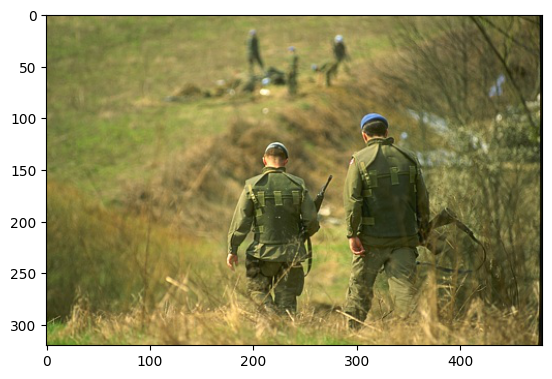

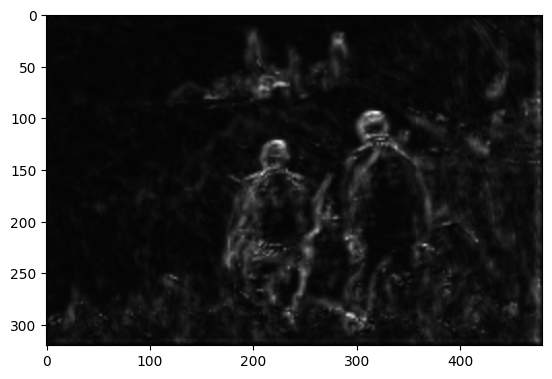

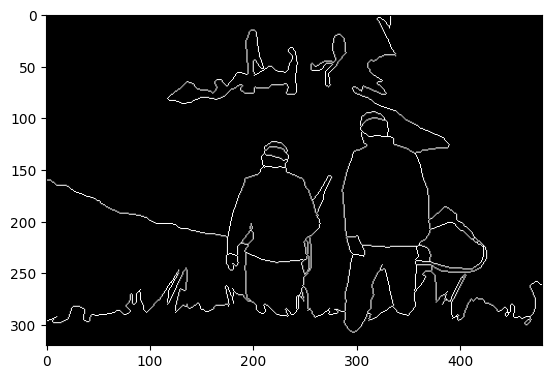

tf.Tensor(0.1058861, shape=(), dtype=float32)


In [ ]:
def visualize(num):
    output = seg_model(np.array([val_images[num]]))
    plt.imshow(val_images[num])
    plt.show()

    plt.imshow(output[0][:,:,0], cmap='gray')
    plt.show()

    plt.imshow(val_annotations[num], cmap='gray')
    plt.show()

    print(pixel_wise_bce(val_annotations[num], output))

    return None

def save(num, prefix = "", path = "/content/drive/MyDrive/gammanet_figs/", 
         mode = "pred"):
    output = seg_model(np.array([val_images[num]]))

    if mode == "pred":
        plt.imshow(output[0][:,:,0], cmap='gray')
        plt.axis('off')
        pred_path = path + prefix + f"_pred_{num}.png"
        plt.savefig(pred_path, bbox_inches='tight')
        plt.close()

    elif mode == "input": 
        plt.imshow(val_images[num], cmap='gray')
        plt.axis('off')
        input_path = path + prefix + f"_input_{num}.png"
        plt.savefig(input_path, bbox_inches='tight')
        plt.close()

    elif mode == "gt": 
        plt.imshow(val_annotations[num], cmap='gray')
        plt.axis('off')
        gt_path = path + prefix + f"_gt_{num}.png"
        plt.savefig(gt_path, bbox_inches='tight')
        plt.close()

    return None

visualize(30)
# save(0, prefix = "timestep2")
modes = ["pred", "input", "gt"]
for mode in modes:
    save(30, prefix = "timestep2_val", mode = mode)



Outputs at Different Timesteps

L2 difference of timestep 1 to timestep 0: 1.586281180381775
L2 difference of timestep 2 to timestep 1: 0.3275076746940613
L2 difference of timestep 3 to timestep 2: 0.07028403133153915
L2 difference of timestep 4 to timestep 3: 0.01548861525952816
L2 difference of timestep 5 to timestep 4: 0.003483775770291686
L2 difference of timestep 6 to timestep 5: 0.000797331565991044
L2 difference of timestep 7 to timestep 6: 0.0001854247966548428


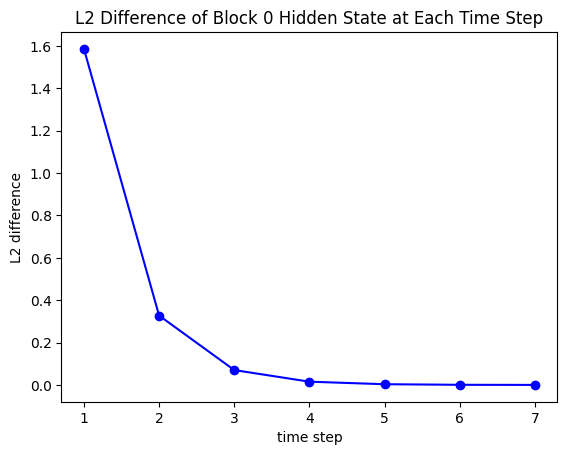

In [ ]:
def timestep_save(num, prefix = "", path = "/content/drive/MyDrive/gammanet_figs/timestep_outputs/", 
                  to_scale = False, scale = None):
    outputs = seg_model.get_timestep_outputs(np.array([val_images[num]]))
    counter = 1
    # save images
    if to_scale:
        for image in outputs:
            plt.imshow(image[0][:,:,0], cmap='gray', vmin = 0, vmax = scale)
            plt.axis('off')
            pred_path = path + prefix + f"_{num}_timestep_{counter}.png"
            plt.savefig(pred_path, bbox_inches='tight')
            plt.close()
            counter += 1
    else:
        for image in outputs:
            plt.imshow(image[0][:,:,0], cmap='gray')
            plt.axis('off')
            pred_path = path + prefix + f"_{num}_timestep_{counter}.png"
            plt.savefig(pred_path, bbox_inches='tight')
            plt.close()
            counter += 1
    return None

def timestep_visualize(num, to_scale = False, scale = "0.3"):
    counter = 1
    outputs = seg_model.get_timestep_outputs(np.array([val_images[num]]))
    if to_scale:
        for image in outputs:
            print(f"Time step: {counter}")
            plt.imshow(image[0][:,:,0], cmap='gray', vmin = 0, vmax = scale)
            plt.show()
            counter += 1
    else:
        for image in outputs:
            print(f"Time step: {counter}")
            plt.imshow(image[0][:,:,0], cmap='gray')
            plt.show()
            counter += 1
    return None

def plot_l2_diff(num, save_fig = False, 
                 path = "/content/drive/MyDrive/gammanet_figs/timestep_outputs/", 
                 name = "l2_diff_plot.png"):
    l2_diffs = []
    outputs = seg_model.get_timestep_outputs(np.array([val_images[num]]))

    # print out the L2 difference at each epoch
    for i in range(1, len(outputs), 1):
        l2_diff = np.linalg.norm(outputs[i].numpy() - outputs[i-1].numpy())
        l2_diffs.append(l2_diff)
        print(f"L2 difference of timestep {i} to timestep {i-1}: {l2_diff}")
    
    # plot the data
    l2_diffs = np.array(l2_diffs)
    indices = np.arange(len(l2_diffs))
    indices += 1
    plt.plot(indices, l2_diffs, marker="o", linestyle="-", color="blue")
    plt.xlabel("time step")
    plt.ylabel("L2 difference")
    plt.title("L2 Difference of Block 0 Hidden State at Each Time Step")
    if save_fig:
        dir = path + name
        plt.savefig(dir)
    plt.show()
    return l2_diffs

# timestep_visualize(30)

l2_diffs = plot_l2_diff(30, save_fig = True)


timestep_save(30, prefix = "ts8_val", to_scale = True, scale = 0.3)

# plt.imshow(output[0][:,:,0], cmap='gray')
# plt.show()
# print(output[0][:,:,0])
# print(outputs[6][0][:,:,0] - outputs[7][0][:,:,0])